## LC Model Search Framework

* Compare 1 season (summer) and 4 temporal steps
* Compare 0 - 1500 training training samples per class in 100 sample increments
* CNN component and RNN components in isolation
* regular CNN+RNN vs conv2dlstm and RNN vs just conv2dLSTM
* Compare to scikit-learn methods using same val and test datasets
* Compare best model across time
    * if major decrease in accuracy then consider training on both 2010 and 2011 data for initial time step
        * consider training on 1999 data to see how it changes the model

In [3]:
import comet_ml
from comet_ml import Experiment
import datetime
import rasterio
import keras
import random
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Bidirectional
from keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, ConvLSTM2D, TimeDistributed, UpSampling2D, Concatenate, LSTM, concatenate
from keras.layers import Activation, BatchNormalization
from keras.optimizers import SGD, Adadelta, Adam
from keras import Input
from keras import Model
import matplotlib.pyplot as plt
import geopandas as gpd
import os
import sys
from sklearn.utils import class_weight
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utilities as util
import importlib
import rnn_tiles
import rnn_pixels
import numpy as np

Using TensorFlow backend.


In [4]:
importlib.reload(rnn_pixels)
importlib.reload(rnn_tiles)
importlib.reload(util)

<module 'utilities' from '/host/Code/florence_mapping/utilities.py'>

In [62]:
exp_name = 'initial_keras_tests_trainedvalonly'
model_name = 'rcnn_9'

Assign your specific GPU so we don't overlap

In [6]:
os.environ["CUDA_VISIBLE_DEVICES"]="0";

Is that GPU and only that GPU visible?

Note that it will always say GPU:0 but you should just see one

In [7]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

Ingest Training Labels

Note that these are monster files so be careful how you inspect them, typically you only want to use the `rasterio` windows option

In [8]:
lc_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/landcover/NLCD_2011_Land_Cover_L48_20190424.img')
canopy_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/canopy/CONUSCartographic_2_8_16/Cartographic/nlcd2011_usfs_conus_canopy_cartographic.img')
class_dict = util.indexed_dictionary

Ingest the landsat imagery stacked into yearly seasonal tiles

In [9]:
tiles = {}
landsat_datasets = {}
tiles['028012'] = ['20110103', '20110308', '20110730', '20110831', '20111103']
tiles['029011'] = ['20110103', '20110308', '20110730', '20110831', '20111018']
tiles['028011'] = ['20110103', '20110308', '20110831', '20111018', '20111103']

for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets

### Load pixels from shapefiles

In [10]:
train_gdf = gpd.read_file('../shapefiles/train_buffered_points140520.shp')
train_px = []
for index, row in train_gdf.iterrows():
    train_px.append(((row['row'], row['col']), row['tile_name']))

random.shuffle(train_px)

len(train_px), train_px[0]

(9000, ((1478, 4379), '028011'))

In [39]:
train_gdf = gpd.read_file('../shapefiles/val_buffered_points140520_val.shp')
train_px = []

per_class_count = [0] * 6
total_per_class_count = [0] * 6

for index, row in train_gdf.iterrows():
    if not row['dubious']:
        total_per_class_count[int(row['label'])] = total_per_class_count[int(row['label'])] + 1
        if per_class_count[int(row['label'])] < 125:
            per_class_count[int(row['label'])] = per_class_count[int(row['label'])] + 1
            train_px.append(((row['row'], row['col']), row['tile_name']))
    
random.shuffle(train_px)

len(train_px), train_px[0]

(750, ((3944.0, 4191.0), '028011'))

In [40]:
val_gdf = gpd.read_file('../shapefiles/test_buffered_points140520_val.shp')
val_px = []

per_class_count = [0] * 6
total_per_class_count = [0] * 6

for index, row in val_gdf.iterrows():
    if not row['dubious']:
        total_per_class_count[int(row['label'])] = total_per_class_count[int(row['label'])] + 1
        if per_class_count[int(row['label'])] < 125:
            per_class_count[int(row['label'])] = per_class_count[int(row['label'])] + 1
            val_px.append(((row['row'], row['col']), row['tile_name']))
    
random.shuffle(val_px)

len(val_px), val_px[0]

(750, ((616.0, 27.0), '029011'))

In [41]:
total_per_class_count, per_class_count

([141, 147, 133, 133, 130, 129], [125, 125, 125, 125, 125, 125])

In [13]:
val_gdf.head()

,canopy,col,label,row,tile_name,x,y,manual_val,dubious,reject,geometry
0,0.0,596.0,0.0,698.0,029011,1802310.0,1643850.0,0,0,0,"POLYGON ((-75.6441512084 36.10119086803808, -7..."
1,0.0,467.0,0.0,3956.0,029011,1798440.0,1546110.0,0,0,0,POLYGON ((-75.91635673586633 35.25513889890946...
2,0.0,749.0,0.0,4096.0,029011,1806900.0,1541910.0,0,0,0,POLYGON ((-75.83449049734953 35.20255815179633...
3,0.0,4780.0,0.0,4536.0,028011,1777830.0,1528710.0,0,0,0,POLYGON ((-76.17979015822588 35.14144967077146...
4,0.0,1120.0,0.0,3425.0,028012,1668030.0,1412040.0,0,0,0,"POLYGON ((-77.6206367137414 34.31532226132933,..."


### Create the RNN

In [14]:
def strangeBlock_v4(input_block, nb_layers, filters):
    x_list = [input_block]
    c_temp = input_block
    for i in range(nb_layers):
        c_l = LSTM(units=filters, activation='elu', return_sequences=True) (c_temp)
        x_list.append(c_l)
        merge = Concatenate()(x_list)
        c_temp = merge
    return c_temp

In [15]:
def make_MLT_dense(in_shape, in_shape_tile, num_classes):
    input_tensor = Input(shape = in_shape, name="rnn_input")
    #single pixel rnn model
    block = strangeBlock_v4(input_tensor, 5, 12)
    block_2 = strangeBlock_v4(block, 3, 20)
    final_block = LSTM(64, activation='softmax', return_sequences=False) (block_2)

    #cnn model
    input_tensor_tile = Input(shape = in_shape_tile, name="tile_input")
    cnn_layer1 = ConvLSTM2D(64, kernel_size=3, activation='elu', return_sequences=True)(input_tensor_tile)
    # batch norm
    cnn_layer2 = ConvLSTM2D(64, kernel_size=3, activation='elu', return_sequences=False) (cnn_layer1)
    maxpool = MaxPooling2D(pool_size=(2, 2), strides=None, padding='same') (cnn_layer2)
    flatten = Flatten()(maxpool)
    concat = concatenate([final_block, flatten])
    
    #denselayer = Dense(64, activation="elu")(concat)
    denselayer = Dense(64, activation="elu")(flatten)
    
    landcover = Dense(num_classes,activation='softmax', name='landcover') (denselayer)
    #canopy = Dense(1, name='canopy') (concat)

    model = Model(inputs=[input_tensor,input_tensor_tile], outputs=[landcover])
    return model

Start the experiments here:

In [63]:
experiment = Experiment(api_key="rMFbl2RlGxNuyyL37dE7qPSfE",
                        project_name="chronos", workspace="clifgray")

COMET INFO: old comet version (3.1.6) detected. current: 3.1.7 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/clifgray/chronos/9e8ac2f226614598a0ad6a0fde6d93cd



In [64]:
experiment.add_tag(exp_name)

In [65]:
tile_size = 9
tile_list = ['028012', '029011', '028011']
class_count = len(class_dict)
epochs = 60
batch_size = 25
steps_division_factor = 10

In [18]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=((tile_size*tile_size*len(tiles['028012'])*7),)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(class_count, activation='softmax'))

model.summary()


model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                378624    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
Total params: 383,174
Trainable params: 383,174
Non-trainable par

In [136]:
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3),
                 activation='relu',
                 input_shape=(len(tiles['028012']),tile_size,tile_size,7)))
model.add(Conv3D(64, (3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(class_count, activation='softmax'))

model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 3, 7, 7, 32)       6080      
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 1, 5, 5, 64)       55360     
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 1, 2, 2, 64)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 2, 2, 64)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)              

In [70]:
model = make_MLT_dense((len(tiles['028012']),7),(len(tiles['028012']),tile_size,tile_size,7), class_count)
model.summary()
model.compile(optimizer=Adam(), loss={'landcover':'categorical_crossentropy'}, metrics={'landcover':['accuracy']}, loss_weights={"landcover":1})

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tile_input (InputLayer)      (None, 5, 9, 9, 7)        0         
_________________________________________________________________
conv_lst_m2d_5 (ConvLSTM2D)  (None, 5, 7, 7, 64)       163840    
_________________________________________________________________
conv_lst_m2d_6 (ConvLSTM2D)  (None, 5, 5, 64)          295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                36928     
_________________________________________________________________
landcover (Dense)            (None, 6)                 390 

#### Train the Model

In [71]:
filepath = 'model_search/' +  model_name + '--' + exp_name + '.hdf5' #your filepath here
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)

In [72]:
train_time_start = datetime.datetime.now()

history = model.fit_generator(generator=tile_gen.tile_generator(train_px, batch_size, flatten=True, canopy=True), 
                steps_per_epoch=len(train_px) // batch_size // steps_division_factor, epochs=epochs, verbose=1,
                validation_data=tile_gen.tile_generator(val_px, batch_size, flatten=True, canopy=True),
                validation_steps=len(val_px) // batch_size,
                callbacks=callbacks_list) 

train_time_stop = datetime.datetime.now()
training_time = train_time_stop - train_time_start

Epoch 1/60
30/30 [==============================] - 5s 150ms/step - loss: 0.7673 - acc: 0.6933 - val_loss: 0.4191 - val_acc: 0.8560

Epoch 00001: val_acc improved from -inf to 0.85600, saving model to model_search/rcnn_9--initial_keras_tests_trainedvalonly.hdf5
Epoch 2/60
30/30 [==============================] - 3s 106ms/step - loss: 0.3048 - acc: 0.8827 - val_loss: 0.4243 - val_acc: 0.8760

Epoch 00002: val_acc improved from 0.85600 to 0.87600, saving model to model_search/rcnn_9--initial_keras_tests_trainedvalonly.hdf5
Epoch 3/60
30/30 [==============================] - 4s 135ms/step - loss: 0.3136 - acc: 0.8987 - val_loss: 0.2936 - val_acc: 0.8907

Epoch 00003: val_acc improved from 0.87600 to 0.89067, saving model to model_search/rcnn_9--initial_keras_tests_trainedvalonly.hdf5
Epoch 4/60
30/30 [==============================] - 4s 134ms/step - loss: 0.1942 - acc: 0.9320 - val_loss: 0.3434 - val_acc: 0.8720

Epoch 00004: val_acc did not improve from 0.89067
Epoch 5/60
30/30 [=======

30/30 [==============================] - 4s 133ms/step - loss: 6.1107e-05 - acc: 1.0000 - val_loss: 0.3528 - val_acc: 0.9453

Epoch 00041: val_acc did not improve from 0.94800
Epoch 42/60
30/30 [==============================] - 4s 133ms/step - loss: 5.6613e-05 - acc: 1.0000 - val_loss: 0.3549 - val_acc: 0.9467

Epoch 00042: val_acc did not improve from 0.94800
Epoch 43/60
30/30 [==============================] - 4s 133ms/step - loss: 5.2620e-05 - acc: 1.0000 - val_loss: 0.3569 - val_acc: 0.9467

Epoch 00043: val_acc did not improve from 0.94800
Epoch 44/60
30/30 [==============================] - 4s 135ms/step - loss: 4.9043e-05 - acc: 1.0000 - val_loss: 0.3588 - val_acc: 0.9467

Epoch 00044: val_acc did not improve from 0.94800
Epoch 45/60
30/30 [==============================] - 4s 134ms/step - loss: 4.5823e-05 - acc: 1.0000 - val_loss: 0.3607 - val_acc: 0.9467

Epoch 00045: val_acc did not improve from 0.94800
Epoch 46/60
30/30 [==============================] - 4s 132ms/step - los

dict_keys(['val_acc', 'val_loss', 'acc', 'loss'])


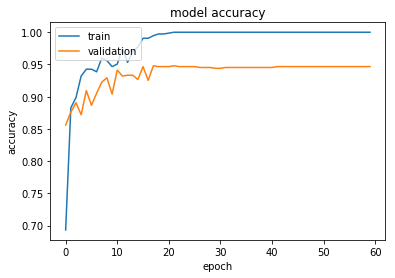

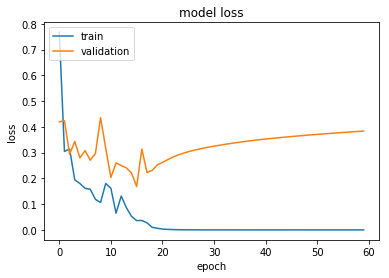

In [73]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
experiment.log_figure(figure=plt, figure_name="model_acc")
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
experiment.log_figure(figure=plt, figure_name="model_loss")
plt.show()

In [74]:
filepath

'model_search/rcnn_9--initial_keras_tests_trainedvalonly.hdf5'

In [75]:
model = keras.models.load_model(filepath)

# Evaluate model

In [76]:
inference_time_start = datetime.datetime.now()

predictions = model.predict_generator(generator = tile_gen.tile_generator(val_px, batch_size=50, flatten=True, canopy=True), steps=len(val_px) // 50, verbose=1)

inference_time_stop = datetime.datetime.now()
inference_time = inference_time_stop - inference_time_start

eval_generator = tile_gen.tile_generator(val_px, batch_size=1, flatten=True, canopy=True)

15/15 [==============================] - 2s 126ms/step


In [77]:
predictions.shape

(750, 6)

In [78]:
lc_predictions = predictions

In [79]:
lc_lab = np.empty(lc_predictions.shape[0])
#canopy_true = np.empty(canopy_pred.shape)
count = 0
while count < len(lc_predictions):
        image_b, label_b = next(eval_generator)
        #print(label_b.shape)
        #label_b = np.argmax(label_b, axis=-1)
        #print(label_b)
        label_b = np.argmax(label_b['landcover'], axis=-1)
        #canopy_true[count] = label_b['canopy']
        lc_lab[count] = label_b
        count += 1
label_index = lc_lab
pred_index = np.argmax(lc_predictions, axis=-1)

Accuracy is 0.948
per_class_acc 1.0
per_class_acc 0.904
per_class_acc 0.968
per_class_acc 0.904
per_class_acc 0.952
per_class_acc 0.96


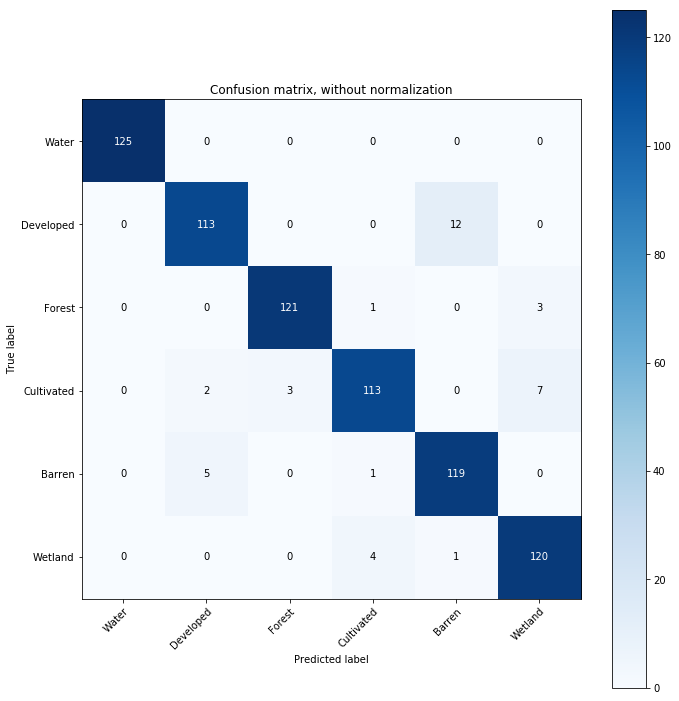

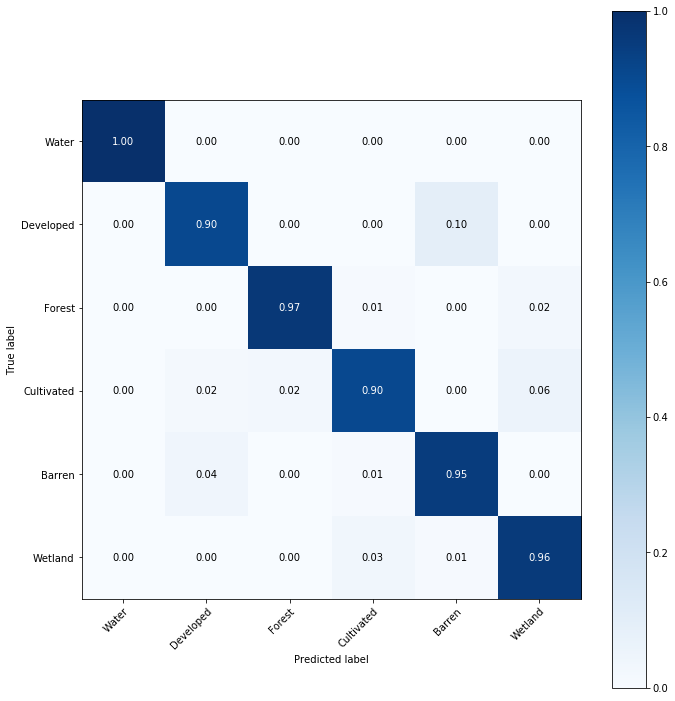

In [80]:
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
_, users_acc, prod_acc = util.plot_confusion_matrix(label_index.astype(np.int), pred_index.astype(np.int), classes=np.array(list(class_dict)),
                      class_dict=class_dict)
experiment.log_figure(figure=plt, figure_name="unnorm_conf_matrix")
# Plot normalized confusion matrix
util.plot_confusion_matrix(label_index.astype(np.int), pred_index.astype(np.int), classes=np.array(list(class_dict)),
                      class_dict=class_dict,
                      normalize=True,
                          title=" ")
experiment.log_figure(figure=plt, figure_name="norm_conf_matrix")
count = 0
per_class_acc = [0] * 6
for i in range(len(label_index)):
    if(label_index[i] == pred_index[i]):
        per_class_acc[int(label_index[i])] = per_class_acc[int(label_index[i])] + 1
        count+=1

val_accuracy=count/len(label_index)
class_acc_dict = {}
print("Accuracy is",val_accuracy)
# this is producer's accuracy
for idx, class_correct in enumerate(per_class_acc):
    class_acc_dict[class_dict[idx]] = round(class_correct/(int(len(label_index)/class_count)),4)
    print('per_class_acc', class_correct/(per_class_count[idx]))

Calculate the accuracy per class
Calculate overall accuracy
Add training samples
add epochs
add tile size

In [81]:
import pandas as pd
import seaborn as sns

experiment_df = pd.DataFrame(columns=['exp_name','model_name','time_steps','train_count','overall_acc', 
                                      'epochs', 'tile_size', 'training_time', 'inference_time',
                                      'water_acc_prod','dev_acc_prod', 'forest_acc_prod', 'cult_acc_prod', 'barren_acc_prod', 'wetland_acc_prod',
                                      'water_acc_user','dev_acc_user', 'forest_acc_user', 'cult_acc_user', 'barren_acc_user', 'wetland_acc_user'])   

In [82]:
experiment_df.loc[len(experiment_df)] = [exp_name, model_name, len(tiles['028012']), len(train_px)/class_count, val_accuracy, 
                                         epochs, tile_size, training_time, inference_time] + list(np.round(prod_acc,3)) + list(np.round(users_acc,3))


In [83]:
experiment_df.tail(5)

,exp_name,model_name,time_steps,train_count,overall_acc,epochs,tile_size,training_time,inference_time,water_acc_prod,...,forest_acc_prod,cult_acc_prod,barren_acc_prod,wetland_acc_prod,water_acc_user,dev_acc_user,forest_acc_user,cult_acc_user,barren_acc_user,wetland_acc_user
0,initial_keras_tests_trainedvalonly,rcnn_9,5,125.0,0.948,60,9,00:04:07.613393,00:00:01.891196,1.0,...,0.968,0.904,0.952,0.96,1.0,0.942,0.976,0.95,0.902,0.923


In [84]:
experiment_df.to_csv('model_search/' + model_name + '--' + exp_name + '.csv')

In [85]:
all_exps = pd.read_csv('model_search/' + 'all_model_runs.csv')
all_exps = pd.concat([all_exps,experiment_df], ignore_index=True)
all_exps.to_csv('model_search/' + 'all_model_runs.csv')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [86]:
params = {
    "exp_name":exp_name,
    "model_name":model_name,
    "landsat_tiles":tiles,
    "cnn_tile_size":tile_size,
    "class_dict":class_dict,
    "batch_size":batch_size,
    "steps_division_factor":steps_division_factor,
    "lc_validation_acc":val_accuracy
}
experiment.log_parameters(params)

In [87]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/clifgray/chronos/9e8ac2f226614598a0ad6a0fde6d93cd
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     acc [77]                  : (0.30666665981213254, 1.0)
COMET INFO:     batch_acc [201]           : (0.07999999821186066, 1.0)
COMET INFO:     batch_loss [201]          : (8.559248954043142e-07, 1.8367645740509033)
COMET INFO:     epoch_duration [77]       : (1.47577236907091, 5.896654153941199)
COMET INFO:     loss [77]                 : (2.0171233743819053e-05, 1.5885132153828938)
COMET INFO:     val_acc [77]              : (0.5693333327770234, 0.9479999939600626)
COMET INFO:     val_loss [77]             : (0.1685162188950926, 1.0602630118529002)
COMET INFO:     validate_batch_acc [236]  : (0.3199999928474426, 1.0)
COMET INFO:     validate

In [37]:
filepath

'model_search/rcnn_9--initial_keras_tests.hdf5'